# Control moment gyroscope

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import scipy as sy

# This is my own script (it is an interface to the pybullet simulator)
import ae353_cmg

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_cmg)

<module 'ae353_cmg' from 'C:\\Users\\Calvin\\ae353-sp22\\projects\\01_cmg\\ae353_cmg.py'>

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `damping` (a non-negative floating-point number, default `0.`) is the coefficient of viscous friction at each joint;
* `load_mass` (a non-negative floating-point number, default `1.`) is the mass of the sphere attached to the platform;
* `roll` (an angle in radians, default `np.pi / 2`) is the roll angle of the ground.

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [2]:
simulator = ae353_cmg.Simulator(
    display=True,
    damping=0.,
    load_mass=1.,
    roll=(np.pi / 2),
)

In [3]:
#define initial conditions
J1z = 0.5 #kg m^2
J2x = 0.001 #kg m^2
J2z = J2x
J3x = 0.01 #kg m^2
J3y = J3x
J3z = J3x
m = 1. #kg
r = 2.0 #m
g = 9.81 #m s^-2
tau_max = 5 #N
v_rotor = 1000 #rad/s

#define variables symbolically
theta1, theta2, omega1, omega2, tau = sym.symbols(
    'theta1,theta2,omega1,omega2,tau')

In [4]:
#define coefficients in EoM
a1 = -J3y + 2.*J3z
a2 = 2.*J3y
a3 = -2.*g*m*r
a4 = 2.*J1z + 2.*J2z + 2.*m*r**2
a5 = 2.*J3z
a6 = (J3y - J3z)/(2.*(J2x + J3x))
a7 = -J3y/(J2x+J3x)
a8 = 1/(J2x+J3x)

In [5]:
# create matrix f = [q_dot1, v_dot1, q_dot2, v_dot2]
f = sym.Matrix([
    omega1,
    (a1*sym.sin(2.*theta2)*omega1*omega2 + a2*sym.cos(theta2)*omega2*v_rotor + a3*sym.sin(theta1))
    /(a4 + a5*(sym.cos(theta2))**2),
    omega2,
    a6*sym.sin(2.*theta2)*(omega1**2) + a7*sym.cos(theta2)*omega1*v_rotor + a8*tau 
])

In [6]:
f

Matrix([
[                                                                                                          omega1],
[(0.01*omega1*omega2*sin(2.0*theta2) + 20.0*omega2*cos(theta2) - 39.24*sin(theta1))/(0.02*cos(theta2)**2 + 9.002)],
[                                                                                                          omega2],
[                                                     -909.090909090909*omega1*cos(theta2) + 90.9090909090909*tau]])

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the gimbal. Modify the `run` function to make the controller behave differently.

In [3]:
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            gimbal_angle,
            gimbal_velocity,
            rotor_velocity
        ):
        
        # FIXME: replace the following line
        gimbal_torque = 0. - (platform_angle - np.pi/4) - (platform_velocity - 0.)
        
        return gimbal_torque

Create an instance of the controller.

In [4]:
controller = Controller()

Reset the simulator with given initial conditions. A low-level controller (separate from yours) will try to ensure that the rotor velocity remains constant.

In [5]:
simulator.reset(
    platform_angle=np.pi/8,
    platform_velocity=0.,
    gimbal_angle=0.,
    gimbal_velocity=0.,
    rotor_velocity=1000.,
)

Reset the controller.

In [6]:
controller.reset()

Choose a camera view (could be `simulator.camera_topview()` or `simulator.camera_sideview()`).

In [7]:
simulator.camera_sideview()
#simulator.camera_topview()

Run the simulator.

In [8]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=20.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
)

Get, show, and save a snapshot of the simulation after the last time step.

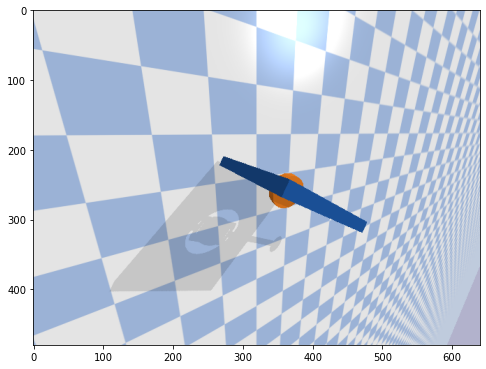

In [9]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

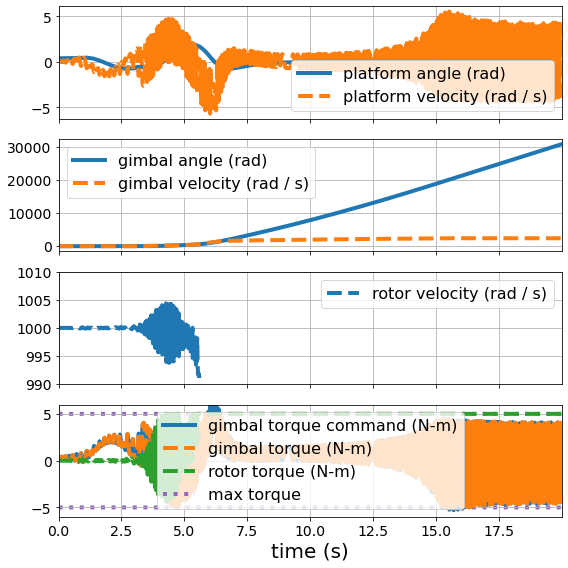

In [10]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_platform, ax_gimbal, ax_rotor, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot platform angle and velocity
ax_platform.plot(
    data['t'], data['platform_angle'],
    label='platform angle (rad)', linewidth=4,
)
ax_platform.plot(
    data['t'], data['platform_velocity'],
    '--', label='platform velocity (rad / s)', linewidth=4,
)
ax_platform.grid()
ax_platform.legend(fontsize=16)
ax_platform.tick_params(labelsize=14)

# Plot gimbal angle and velocity
ax_gimbal.plot(
    data['t'], data['gimbal_angle'],
    label='gimbal angle (rad)', linewidth=4,
)
ax_gimbal.plot(
    data['t'], data['gimbal_velocity'],
    '--', label='gimbal velocity (rad / s)', linewidth=4,
)
ax_gimbal.grid()
ax_gimbal.legend(fontsize=16)
ax_gimbal.tick_params(labelsize=14)

# Plot rotor velocity
ax_rotor.plot(
    data['t'], data['rotor_velocity'],
    '--', label='rotor velocity (rad / s)', linewidth=4,
)
ax_rotor.grid()
ax_rotor.legend(fontsize=16)
ax_rotor.tick_params(labelsize=14)
ax_rotor.set_ylim(simulator.rotor_velocity - 10., simulator.rotor_velocity + 10.)

# Plot torques
ax_torque.plot(
    data['t'], data['gimbal_torque_command'],
    label='gimbal torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['gimbal_torque'],
    '--', label='gimbal torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['rotor_torque'],
    '--', label='rotor torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label='max torque', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [ ]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)